In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from sutils import *
import os, json
from glob import glob

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 10

dataset = "fashion" # or "numbers"

# input image dimensions
img_rows, img_cols = 28, 28

## Load the MNIST Fashion

In [3]:
def load_mnist(path, kind='train'):
    import os
    import struct
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        struct.unpack(">IIII", imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [4]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

path = './data/fashion/'

if dataset == "fashion":
    x_train, y_train = load_mnist(path, kind='train')
    x_test, y_test = load_mnist(path, kind='t10k')

In [5]:
def show_digit(index):
    label = y_train[index]#.argmax(axis=0)
    # Reshape 784 array into 28x28 image
    image = x_train[index].reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.title('Training data, index: %d,  Label: %d' % (index, label))
    plt.imshow(image, cmap='gray_r')
    plt.show()
    

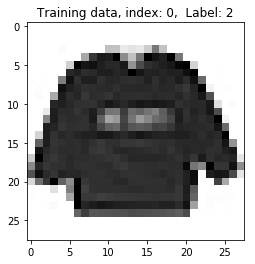

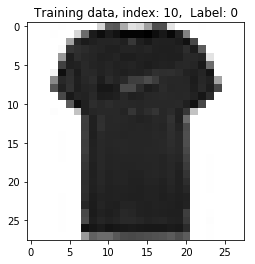

In [6]:
show_digit(0)
show_digit(10)


In [7]:
# reshape the data into format (width, Height, channels)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [8]:
input_shape

(28, 28, 1)

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
Inp=Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',name = 'Conv_01')(Inp)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
x = Dropout(0.25,name = 'Dropout_01')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(128, activation='relu',name = 'Dense_01')(x)
#x = BatchNormalization()(x)
x = Dropout(0.5,name = 'Dropout_02')(x)
output = Dense(num_classes, activation='softmax',name = 'Dense_02')(x)

In [12]:
model = Model(Inp,output)

## Calculating the number of parameters for Convolution Networks

Formula is (filters x (kernel_height x kernel_width) x inputs)+ 1 x filters = parameters

Conv_01 = 32 Filters , 3x3 Kernel = (32 x (3x3) x 1 input) + 1bias x filters = 320 parameters  
Conv_02 = 64 Filters , 3x3 Kernel = (64 x (3x3) x 32 inputs) + 1bias x filters = 18496 parameters 

Dense_1 = (9216 inputs * 128 units)+ 128 bias = 1,179,776  
Dense_2 = (128 inputs * 10 units) +10 bias = 1290

1,200,394 - batchnorm (adds 512 more parameters)
1,199,882 - no batchnorm

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 26, 26, 32)        320       
_________________________________________________________________
Conv_02 (Conv2D)             (None, 24, 24, 64)        18496     
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
Flatten_01 (Flatten)         (None, 9216)              0         
_________________________________________________________________
Dense_01 (Dense)             (None, 128)               1179776   
__________

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [15]:
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = None,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 125s - loss: 0.6472 - acc: 0.7725 - val_loss: 0.3841 - val_acc: 0.8701
Epoch 2/10
60000/60000 [==============================] - 121s - loss: 0.4061 - acc: 0.8559 - val_loss: 0.3188 - val_acc: 0.8876
Epoch 3/10
60000/60000 [==============================] - 123s - loss: 0.3536 - acc: 0.8751 - val_loss: 0.2897 - val_acc: 0.8987
Epoch 4/10
60000/60000 [==============================] - 125s - loss: 0.3257 - acc: 0.8860 - val_loss: 0.2738 - val_acc: 0.9007
Epoch 5/10
60000/60000 [==============================] - 115s - loss: 0.3021 - acc: 0.8925 - val_loss: 0.2681 - val_acc: 0.9055
Epoch 6/10
60000/60000 [==============================] - 115s - loss: 0.2863 - acc: 0.8993 - val_loss: 0.2471 - val_acc: 0.9100
Epoch 7/10
60000/60000 [==============================] - 132s - loss: 0.2716 - acc: 0.9045 - val_loss: 0.2410 - val_acc: 0.9140
Epoch 8/10
60000/60000 [=======================

In [17]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate(x_test, y_test,
          batch_size=batch_size)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

 9984/10000 [============================>.] - ETA: 0sModel Accuracy = 0.92
Model Loss = 0.23


In [ ]:
preds = model.predict(x_test)

In [ ]:
model.save_weights('basic_cnn.h5')

In [ ]:
model.save('cnn_model')

In [ ]:
model.evaluate??

In [ ]:
Inp=Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',name = 'Conv_01')(Inp)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
x = Conv2D(128, (3, 3), activation='relu',name = 'Conv_03')(x)
x = Conv2D(256, (3, 3), activation='relu',name = 'Conv_04')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_02')(x)
x = Dropout(0.25,name = 'Dropout_01')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(128, activation='relu',name = 'Dense_01')(x)
x = Dropout(0.5,name = 'Dropout_02')(x)
output = Dense(num_classes, activation='softmax',name = 'Dense_02')(x)

In [ ]:
model = Model(Inp,output)

## Calculating the number of parameters for Convolution Networks

Formula is (filters x (kernel_height x kernel_width) x inputs) 1 x filters = parameters

Conv_01 = 32 Filters , 3x3 Kernel = (32 x (3x3) x 1 input) + 1bias x filters = 320 parameters  
Conv_02 = 64 Filters , 3x3 Kernel = (64 x (3x3) x 32 inputs) + 1bias x filters = 18496 parameters   
Conv_03 = 128 Filters , 3x3 Kernel = (128 x (3x3) x 64 input) + 1bias x filters = 73856 parameters    
Conv_04 = 256 Filters , 3x3 Kernel = (256 x (3x3) x 128 inputs) + 1bias x filters = 295168 parameters 

Dense_1 = (4096 inputs * 128 units)+ 128 bias = 524,416  
Dense_2 = (128 inputs * 10 units) +10 bias = 1290

In [ ]:
model.summary()